In [1]:
import pandas as pd
#from get_specific_data import fetch_data
from datetime import datetime
import yfinance as yf
from scipy.stats import linregress
import numpy as np
import ta
import os
import matplotlib.pyplot as plt

In [2]:
def exponential_regression(x, y):
    #log of closing price
    log_y = np.log(y)

    #get slope, and r_value
    slope, intercept, r_value, _, _ = linregress(x, log_y)

    '''
    r**2 -> coefficient of determinent
    ranges from 0 - 1
    ''' 
    return slope, intercept, r_value**2 

In [3]:
def annualize_return(daily_slope):
    return ((np.exp(daily_slope) ** 250) - 1) * 100

In [4]:
def calculate_adjusted_return(df, ticker):
    '''
    returns -> list [ticker, slope, annualized_return, adjusted return]
    '''

    #getting last 90 days data
    x = np.arange(90)                   #list from 0-89
    y = df['close'].iloc[-90:].values   #last 90 closing prices


    slope, intercept, r2 = exponential_regression(x, y)
    annualized_return = annualize_return(slope)
    
    adjusted_return = annualized_return * r2
    

    return [ticker, slope, annualized_return, adjusted_return]

In [5]:
def check_circuits(df, upper_circuit=20, lower_circuit=20):
    '''
    hit -> if circuit was hit in the last 90 days
    freq -> frequency of circuit hits 
    '''

    hit = False
    freq = 0

    # Filtering the last 90 days data
    days_90 = df.iloc[-90:, :].copy()

    # Calculate the upper and lower circuit levels
    days_90.loc[:, 'upper_circuit'] = days_90['close'].shift(1) * (1 + upper_circuit / 100)
    days_90.loc[:, 'lower_circuit'] = days_90['close'].shift(1) * (1 - lower_circuit / 100)

    # Initialize the circuit columns 
    days_90['Hit Upper Circuit'] = False
    days_90['Hit Lower Circuit'] = False

    # Explicitly cast columns to bool dtype
    days_90['Hit Upper Circuit'] = days_90['Hit Upper Circuit'].astype(bool)
    days_90['Hit Lower Circuit'] = days_90['Hit Lower Circuit'].astype(bool)

   
    days_90.loc[days_90['high'] >= days_90['upper_circuit'], 'Hit Upper Circuit'] = True    
    days_90.loc[days_90['low'] <= days_90['lower_circuit'], 'Hit Lower Circuit'] = True

    # Count the number of hits for both upper and lower circuits
    upper_circuit_hits = days_90['Hit Upper Circuit'].sum()
    lower_circuit_hits = days_90['Hit Lower Circuit'].sum()
    freq = upper_circuit_hits + lower_circuit_hits

    # Determine if there were any hits
    if freq > 0:
        hit = True

    return hit, freq


In [6]:
def check_circuits_on_full_df(df, upper_circuit=20, lower_circuit=20):
    '''
    function only for simulation

    Returns two new columns:
    - `circuit_hit_90d`: True/False if a circuit was hit in the last 90 days.
    - `circuit_freq_90d`: The frequency of circuit hits in the last 90 days.
    '''
    circuit_hit_90d = []
    circuit_freq_90d = []

    for i in range(len(df)):
        if i < 90:
            # If we have less than 90 rows, use what we have
            sub_df = df.iloc[:i+1]
        else:
            # Otherwise, use the last 90 rows
            sub_df = df.iloc[i-89:i+1]

        hit, freq = check_circuits(sub_df, upper_circuit, lower_circuit)
        circuit_hit_90d.append(hit)
        circuit_freq_90d.append(freq)

    df['circuit_hit_90d'] = circuit_hit_90d
    df['circuit_freq_90d'] = circuit_freq_90d

    return df

In [7]:
def calculate_atr(df, window=14):
    atr = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=window)
    # Calculate RMA manually
    rma_atr = atr.average_true_range().ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    return rma_atr

In [8]:
def get_sma(df, window = 200):
    df.columns = [i.lower() for i in df.columns]
    #SMA calcluation
    df['sma_' + str(window)] = ta.trend.sma_indicator(df['close'], window=window)
    df['sma_' + str(window)+'_above'] = df['close'] > df['sma_' + str(window)] 
    return df

In [9]:
ticker = "^CRSLDX"

# Fetch the historical data
nifty500_data = yf.download(ticker, start="2022-01-01", end="2024-08-31")
print(nifty500_data.shape)
nifty500_data = get_sma(nifty500_data)
nifty500_stocks = pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
#filtering csv to EQ and getting only symbol column
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']
nifty500_data.to_csv('nifty500.csv')

nifty500_data = pd.read_csv('nifty500.csv')
nifty500_stocks= pd.read_csv('F:\\Bot\\csv_files\\nifty500list.csv')
nifty500_stocks = nifty500_stocks.loc[nifty500_stocks['Series'] == 'EQ', 'Symbol']


[*********************100%***********************]  1 of 1 completed

(653, 6)


In [10]:
nifty500_data.tail()

,Date,open,high,low,close,adj close,volume,sma_200,sma_200_above
648,2024-08-26,23514.300781,23579.750000,23466.750000,23561.750000,23561.750000,19994300,20502.214531,True
649,2024-08-27,23592.000000,23633.199219,23555.550781,23604.849609,23604.849609,22130300,20536.411533,True
650,2024-08-28,23646.800781,23679.349609,23547.250000,23615.949219,23615.949219,24488600,20570.360781,True
651,2024-08-29,23618.250000,23664.349609,23494.449219,23631.400391,23631.400391,29804300,20604.512285,True
652,2024-08-30,23728.550781,23766.400391,23673.949219,23734.550781,23734.550781,70150200,20639.520293,True


In [11]:
def get_positional_data(nifty500_stocks, specific_date = datetime.today().date() - pd.Timedelta(days = 1),  num_periods = 400, path = 'F:\\Bot\\data dump\\outputs\\'):
    
    '''
    nifty500_stocks ->  list of stock names
    specific_date   ->  extract data till previous date
    numperiods      ->  number of datapoints (days) to be extracted from csv
    path            ->  path for csv file for stock data

    returns a filtered dataframe
    
    '''
    
    main_df = pd.DataFrame(columns=['stock_name', 'prev_close', 'slope', 'annualized_return', 'adjusted_return', 'prev_sma_100_above', 'circuit_hitted', 'circuit_freq', 'prev_atr_20'])


    for i in nifty500_stocks:
        try:
            
            data = pd.read_csv(path + i + '.csv')  # readin file
            data['Date'] = pd.to_datetime(data['Date']).dt.date  #converting to datetime columns
            
            # Filter data up to the specific date
            data = data[data['Date'] <= specific_date]
            
            # Select the last 400 data points
            data = data.iloc[-num_periods:]
            

            # If less than 400 data points, continue to next stock
            if len(data) < num_periods:
                continue

        except Exception as e:
            print(e)
            continue
        
        # Getting sma
        data = get_sma(data, 100)

        # Circuit hit
        hit, freq = check_circuits(data)    
        
        # Getting atr
        data['atr_20'] = calculate_atr(data, 20)
        
        
        
        # Getting slope, annualized return, adjusted_return
        l = calculate_adjusted_return(data, i)
        new_row = {
            'stock_name': l[0],
            'prev_close': data['close'].iloc[-1],
            'slope': l[1],
            'annualized_return': l[2],
            'adjusted_return': l[3],
            'prev_sma_100_above': data['sma_100_above'].iloc[-1],
            'circuit_hitted': hit,
            'circuit_freq': freq,
            'prev_atr_20': data['atr_20'].iloc[-1]
        }
        
        # Adding to dataframe
        main_df.loc[len(main_df.index)] = new_row
    

    filtered_df = main_df.sort_values(by='adjusted_return', ascending=False)[:100]
    
    account_value = 1000000
    risk_factor = 0.002

    #filtering
    filtered_df['no_of_shares'] = [account_value * risk_factor]/filtered_df['prev_atr_20']
    filtered_df['no_of_shares'] = filtered_df['no_of_shares'].astype(int)
    
    '''filtered_df = filtered_df.loc[filtered_df['prev_sma_100_above'] == True]
    filtered_df = filtered_df.loc[filtered_df['circuit_hitted'] == False]'''

    #checking till our cumulative cash reached close to account value
    filtered_df['invested_amount'] = filtered_df['no_of_shares'] * filtered_df['prev_close']
    filtered_df['cumulative_invested_amount'] = filtered_df['invested_amount'].cumsum()

    '''
    filtered_df.reset_index(drop=True, inplace=True)

    index = filtered_df[filtered_df['cumulative_cash_used'] > account_value].index[0]
    # Slice the DataFrame
    filtered_df = filtered_df.loc[:index-1]
    '''

    
    
    return filtered_df

In [12]:
def get_and_save_positional_data(nifty500_stocks, specific_date):
    # Define the filename based on the specific date
    filename = f"positions_{specific_date}.csv"
    filepath = os.path.join("F:\Bot\MomentumStrategy\positionalData", filename)

    # Check if the file already exists
    if os.path.exists(filepath):
        print(f"File {filename} already exists. Loading existing data.")
        position_data = pd.read_csv(filepath)
    else:
        # Generate the positional data
        position_data = get_positional_data(nifty500_stocks, specific_date)
        
        # Save to CSV
        position_data.to_csv(filepath, index=False)
        print(f"Positional data saved to {filename}.")

    return position_data

In [22]:
data_dict = {} #stores data from csv

In [35]:
initial_cash = 1000000  # Example starting cash
cash_in_hand = initial_cash
portfolio = {} 

In [36]:
def simulate(start_date, end_date, nifty500_data):
    
    global cash_in_hand, portfolio
    
    equity = []
    dates = []

    nifty500_data['Date'] = pd.to_datetime(nifty500_data['Date'])

    current_date = start_date
    
    while current_date <= end_date:
        
        positional_data = get_and_save_positional_data(nifty500_stocks, current_date)

        #exit conditions
        stock_to_exit = []
        for stock in portfolio:
            try:
                sma_100 = positional_data.loc[positional_data['stock_name'] == stock, 'prev_sma_100_above'].values[0]
                circuit_check = positional_data.loc[positional_data['stock_name'] == stock, 'circuit_hitted'].values[0]
                stock_index = positional_data.loc[positional_data['stock_name'] == stock].index[0] + 1
                
                #print(sma_100, circuit_check, stock_index)
                
                if not sma_100:
                    print(stock + ' below sma')
                    stock_to_exit.append(stock)

                elif circuit_check: 
                    stock_to_exit.append(stock)
                    print(stock + ' circuit hit')


                elif stock_index > 75:
                    print(stock + ' index below 75', stock_index)
                    
                    stock_to_exit.append(stock)

            except Exception as e:

                if stock in portfolio.keys():
                    
                    #condition where the stock reaches below 100 rank suddenly and throw error since sma_100
                    #and rest of the value cannot be found and the file contains top 100 stocks only
                    print(stock + ' below  top 100')
                    stock_to_exit.append(stock)
            
            
        #exiting and adding to cash in hand
        for stock in stock_to_exit:
            sell_price = None
            
            #already loaded since it was bought once
            stock_df = data_dict[stock]
            
            #getting the days opening price of stock
            sell_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]        
        
            exit_amount = sell_price * portfolio[stock]['shares']
            print('Sold ', stock, ' at ', sell_price, ' Date ', current_date, 'realized gain' , exit_amount - portfolio[stock]['invested_amount'])
            cash_in_hand += exit_amount
            
            del portfolio[stock]


        
        #rebalancing : reducing shares
        for i, row in positional_data.iterrows():
            if row['stock_name'] in portfolio:
                current_shares = portfolio[row['stock_name']]['shares']
                new_shares = row['no_of_shares']

                # Check if the new number of shares deviates by more than 5%
                if abs(new_shares - current_shares) / current_shares > 0.05 and current_shares > new_shares:
                    #sell
                    shares_to_sell = current_shares - new_shares
                    
                    #loading stock data
                    stock_df = data_dict[row['stock_name']]
                    

                    sell_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]        

                    sell_amount = shares_to_sell * sell_price

                    portfolio[row['stock_name']]['shares'] = new_shares
                    portfolio[row['stock_name']]['invested_amount'] = portfolio[row['stock_name']]['invested_amount'] - sell_amount
                    
                    cash_in_hand += sell_amount
                    print('Reduced ' + row['stock_name'] + ' to ' + str(new_shares) + ' shares on ' + str(current_date))

        
        #rebalancing : adding shares
        for i, row in positional_data.iterrows():
            
            if row['stock_name'] in portfolio:
                current_shares = portfolio[row['stock_name']]['shares']
                new_shares = row['no_of_shares']

                # Check if the new number of shares is significantly more (more than 5% increase)
                if new_shares > current_shares and abs(new_shares - current_shares) / current_shares > 0.05:
                    
                    # Calculate the amount of shares to buy
                    shares_to_buy = new_shares - current_shares
                    
                    #loading stock data
                    stock_df = data_dict[row['stock_name']]
                    
                    
                    #getting current opening buy price
                    buy_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]

                    
                    buy_amount = shares_to_buy * buy_price

                    # Check if we have enough cash to buy
                    if cash_in_hand >= buy_amount:
                        # Calculate the new average price
                        total_shares = current_shares + shares_to_buy
                        new_invested_amount = (
                            portfolio[row['stock_name']]['invested_amount'] + buy_amount
                        )

                        # Update the portfolio
                        portfolio[row['stock_name']]['shares'] = total_shares
                        portfolio[row['stock_name']]['invested_amount'] = new_invested_amount / total_shares * total_shares
                        cash_in_hand -= buy_amount

                        print('Increased ' + row['stock_name'] + ' to ' + str(total_shares) + ' shares on ' + str(current_date))



        #buying
        for i, row in positional_data.iterrows():
            
            if row['stock_name'] in portfolio:
                    continue
            
            try:                
                #if we have enough cash and nifty 500 is above 200SMA
                if cash_in_hand > row['invested_amount'] and nifty500_data.loc[nifty500_data['Date'].dt.date <= current_date, 'sma_200_above'].values[-1]:
                    
                    #checking if stock above 100sma and no circuit hit
                    if row['prev_sma_100_above'] and not row['circuit_hitted']:

                        ##getting opening data for current day
                        if row['stock_name'] not in data_dict:
                            
                            #load data to get current day opening price
                            stock_df = pd.read_csv("F:\\Bot\\data dump\\outputs\\" + row['stock_name'] + '.csv')
                            stock_df['Date'] = pd.to_datetime(stock_df['Date'])
                            stock_df['Date'] = stock_df['Date'].dt.date

                        
                            data_dict[row['stock_name']] = stock_df
                            
                            
                            #filtering stock till todays data point to enter as sson as market opens
                        else:
                            stock_df = data_dict[row['stock_name']]
                        
                        current_opening_price = stock_df.loc[stock_df['Date'] >= current_date, 'open'].values[0]
                        current_entry_date = stock_df.loc[stock_df['Date'] >= current_date, 'Date'].values[0]


                        #adding to porfolio dict.
                        portfolio[row['stock_name']] = {
                            'entry_date' : current_entry_date,
                            'shares' : row['no_of_shares'],
                            'invested_amount' : row['no_of_shares'] * current_opening_price
                        }

                        #decreasing our cash in hand
                        cash_in_hand -= portfolio[row['stock_name']]['invested_amount']

                        print('Bought ' + row['stock_name'] + ' date ', portfolio[row['stock_name']]['entry_date'] , 'at avg price of ', current_opening_price)
        
            

            except Exception as e:
                print('error here')
                print(e)
                print(row)


                
        #calculating equity
        equity_value = 0
        invested = 0
        for i, row in positional_data.iterrows():

            if row['stock_name'] in portfolio.keys():
                stock_df = data_dict[row['stock_name']]    
                #getting current opening buy price
                close_price = stock_df.loc[stock_df['Date'] >= current_date, 'close'].values[0]

                invested += portfolio[row['stock_name']]['shares'] * close_price
        
        
        equity_value = invested + cash_in_hand
        print(current_date,invested, cash_in_hand, equity_value)
        equity.append(equity_value)
        dates.append(current_date)



        current_date += pd.Timedelta(weeks=1)

    
    return equity, dates

In [37]:
start_date = datetime(2023, 1, 1).date()
end_date = datetime(2024, 8, 30).date()

equity, dates = simulate(start_date, end_date, nifty500_data)

File positions_2023-01-01.csv already exists. Loading existing data.
Bought RVNL date  2023-01-02 at avg price of  68.25
Bought MAZDOCK date  2023-01-02 at avg price of  798.0
Bought UNIONBANK date  2023-01-02 at avg price of  80.9
Bought BANKINDIA date  2023-01-02 at avg price of  88.95
Bought GODFRYPHLP date  2023-01-02 at avg price of  1986.0
Bought J&KBANK date  2023-01-02 at avg price of  56.9
Bought MAHABANK date  2023-01-02 at avg price of  30.85
Bought FACT date  2023-01-02 at avg price of  383.4
Bought JSL date  2023-01-02 at avg price of  241.0
Bought CENTRALBK date  2023-01-02 at avg price of  32.4
Bought COCHINSHIP date  2023-01-02 at avg price of  265.48
Bought IOB date  2023-01-02 at avg price of  32.4
Bought INDIANB date  2023-01-02 at avg price of  287.0
Bought GRSE date  2023-01-02 at avg price of  487.0
Bought JKLAKSHMI date  2023-01-02 at avg price of  822.55
Bought PNB date  2023-01-02 at avg price of  56.8
Bought IRCON date  2023-01-02 at avg price of  60.0
Bought 

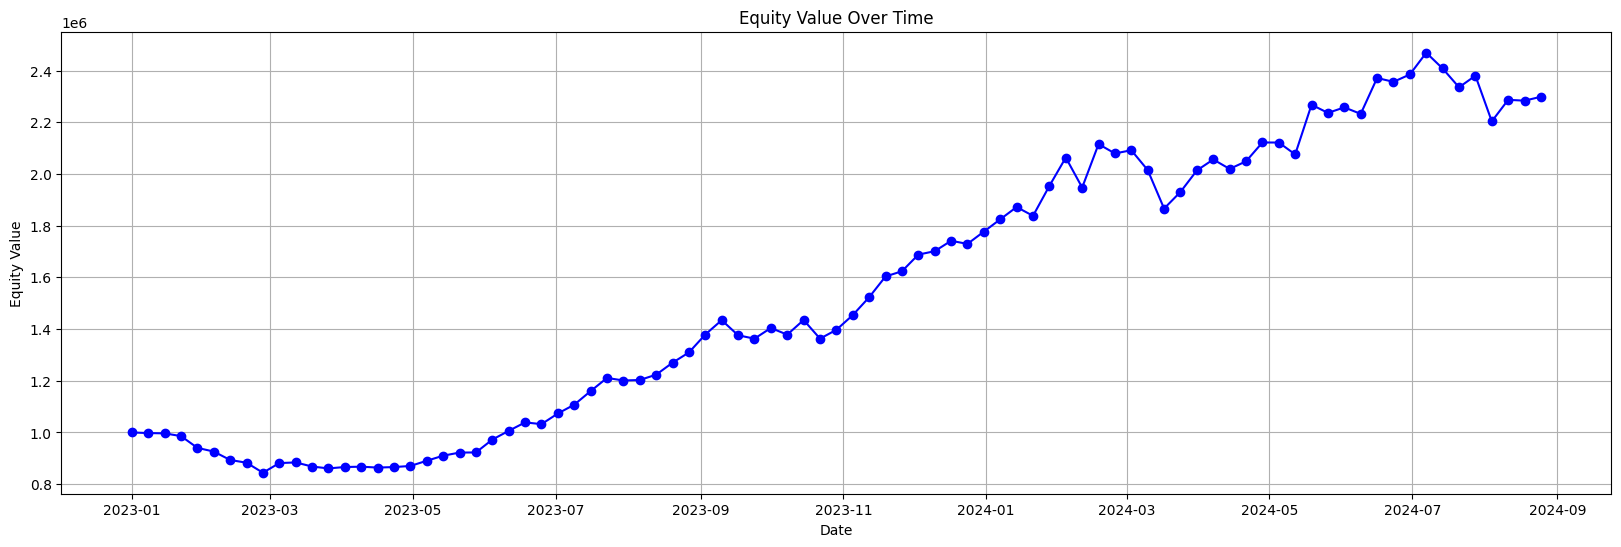

In [38]:
plt.figure(figsize=(20, 6))
plt.plot(dates,equity, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.title('Equity Value Over Time')
plt.grid(True)
plt.show()

In [34]:
equity

[1011428.93,
 1052766.0500000003,
 1055084.0499999998,
 1035060.3100000003,
 1100926.47,
 1165356.2600000002,
 1086208.36,
 1179781.9600000002,
 1169292.4800000002,
 1183438.43,
 1144204.1800000002,
 1046101.89,
 1091549.27,
 1147582.9699999997,
 1179103.53,
 1148264.3000000003,
 1163376.9599999997,
 1207277.73,
 1202320.0799999998,
 1155874.68,
 1246774.6600000004,
 1228226.93,
 1234118.0800000003,
 1207430.0099999998,
 1279050.9599999997,
 1268909.41,
 1310864.16,
 1351470.06,
 1319212.7599999995,
 1271942.34,
 1284805.0499999998,
 1186985.2500000002,
 1231591.1999999997,
 1223186.8,
 1231377.05]